<a href="https://colab.research.google.com/github/ritwikraha/GenerativeFill-with-Keras-and-Diffusers/blob/main/demo-gen-fill-gsam-diff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup and Imports

In [1]:
!pip install --upgrade -qq keras-cv tensorflow
!pip install --upgrade -qq keras

!pip install --upgrade -qq diffusers accelerate

!pip install --upgrade -qq git+https://github.com/IDEA-Research/GroundingDINO.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0.post1 requires keras<2.16,>=2.15.0, but you have keras 3.0.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 33.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
!wget -q https://raw.githubusercontent.com/IDEA-Research/GroundingDINO/v0.1.0-alpha2/groundingdino/config/GroundingDINO_SwinT_OGC.py

In [3]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import ops
import keras_cv

from diffusers import AutoPipelineForInpainting
from groundingdino.util.inference import Model as GroundingDINO

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## Configuration

In [4]:
GDINO_CONFIG_PATH = "GroundingDINO_SwinT_OGC.py"
GDINO_WEIGHTS_PATH = "groundingdino_swint_ogc.pth"
SAM_MODEL_NAME = "sam_huge_sa1b"

IMAGE_SIZE = (1024, 1024)

## Get the Image

1236492/1236492 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


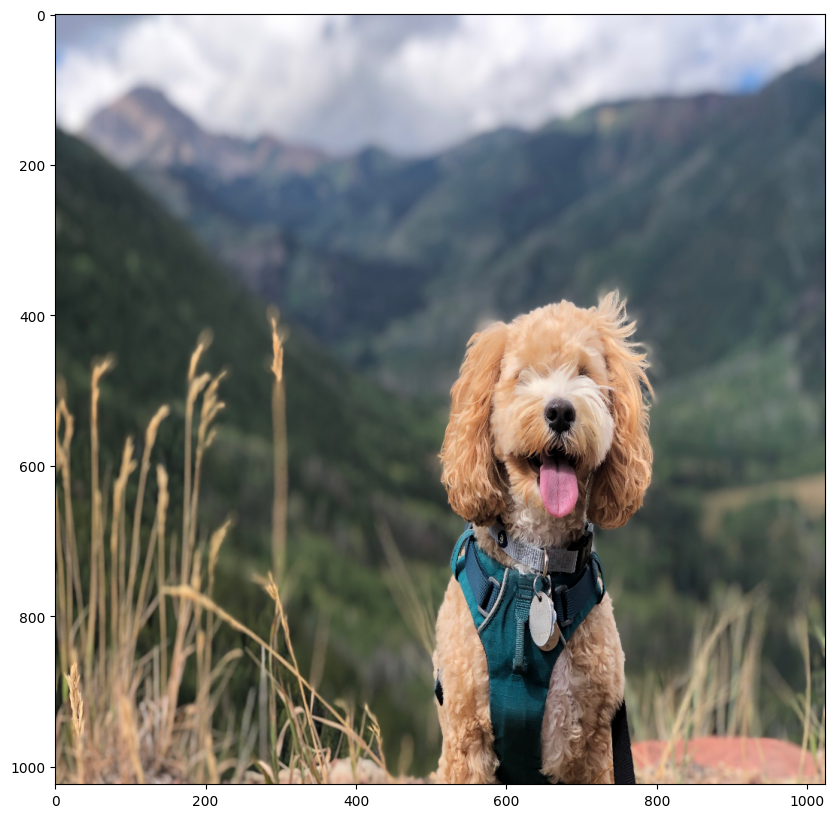

In [5]:
image_url = "https://storage.googleapis.com/keras-cv/test-images/mountain-dog.jpeg"
filepath = keras.utils.get_file(origin=image_url)
image = np.array(keras.utils.load_img(filepath))
image = ops.convert_to_numpy(ops.image.resize(image[None, ...], IMAGE_SIZE)[0])

plt.figure(figsize=(10, 10))
plt.imshow(image / 255.0)
plt.axis("on")
plt.show()

## Utilities

In [6]:
def show_mask(mask, ax):
    color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    box = box.reshape(-1)
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )

## Models

In [7]:
sam_model = keras_cv.models.SegmentAnythingModel.from_preset(SAM_MODEL_NAME)
grounding_dino = GroundingDINO(GDINO_CONFIG_PATH, GDINO_WEIGHTS_PATH)

100%|██████████| 3.38k/3.38k [00:00<00:00, 3.88MB/s]
100%|██████████| 2.39G/2.39G [02:31<00:00, 16.9MB/s]
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## Grounding-DINO with SAM

In [8]:
object_name = "collar"

# Grounding DINO
boxes = grounding_dino.predict_with_caption(
    image.astype(np.uint8),
    object_name,
)
boxes = np.array(boxes[0].xyxy)

# SAM
outputs = sam_model.predict(
    {
        "images": np.repeat(image[np.newaxis, ...], boxes.shape[0], axis=0),
        "boxes": boxes.reshape(-1, 1, 2, 2),
    },
    batch_size=1,
)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step


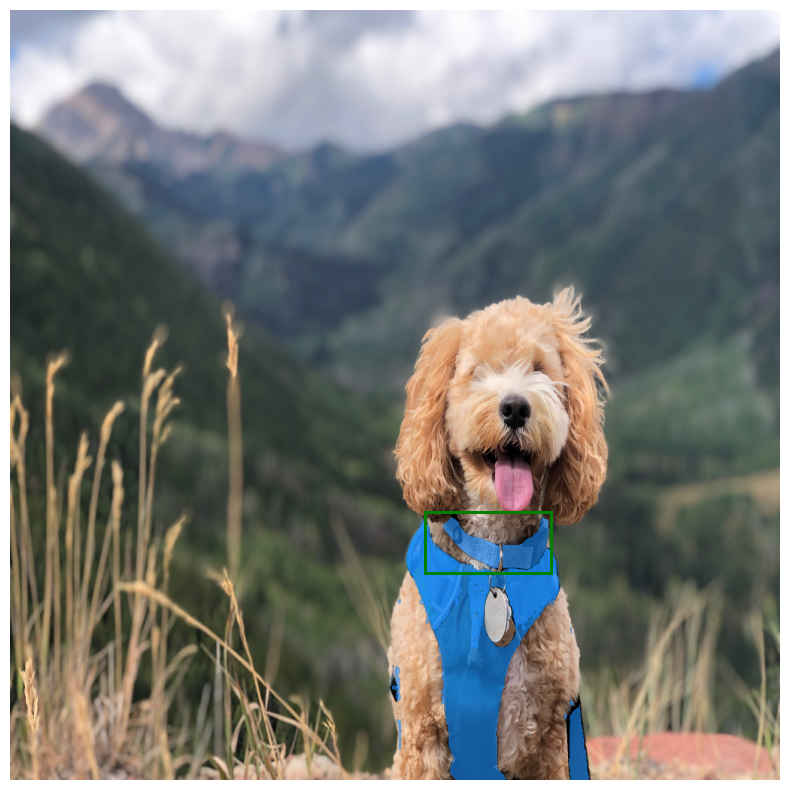

In [9]:
plt.figure(figsize=(10, 10))
plt.imshow(image / 255.0)

for mask in outputs["masks"]:
    mask = ops.image.resize(mask[0][..., None], IMAGE_SIZE)[..., 0]
    mask = ops.convert_to_numpy(mask) > 0.0
    show_mask(mask, plt.gca())
    show_box(boxes, plt.gca())

plt.axis("off")
plt.show()

## Inpainting

In [11]:
import torch

In [12]:
pipeline = AutoPipelineForInpainting.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float16,
    variant="fp16",
)
pipeline.enable_model_cpu_offload()

model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [13]:
prompt = "a bow tie, highly detailed, 8k"
output = pipeline(
    prompt=prompt,
    image=Image.fromarray(image.astype(np.uint8)),
    mask_image=Image.fromarray(mask),
    strength=0.6
).images[0]

  0%|          | 0/30 [00:00<?, ?it/s]

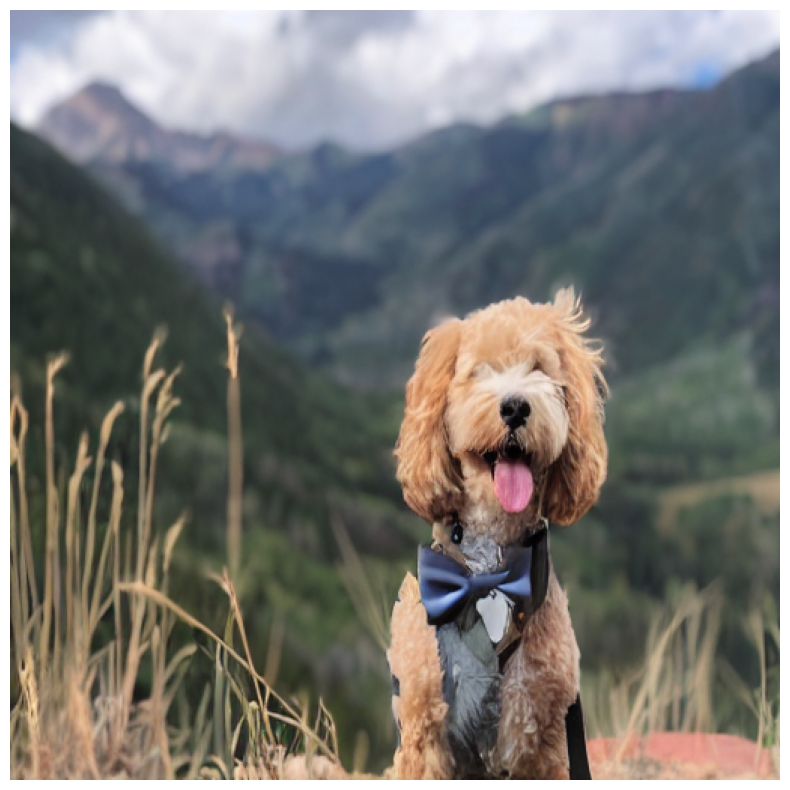

In [14]:
plt.figure(figsize=(10, 10))
plt.imshow(output)
plt.axis("off")
plt.show()